# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
# # import scipy.io as sio
# # import hdf5storage
# # datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
# # conjunto_datos= datos_matlab.get('photodefbox2_todo')
# # conjunto_datos.shape
# npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
# npzfile.files

# # conjunto_datos_entradasA=npzfile['arr_0']
# # conjunto_datos_entradasB=npzfile['arr_1']
# # conjunto_datos_salidas=npzfile['arr_2']
# entradas_sensorsA1=npzfile['arr_0']
# entradas_sensorsB1=npzfile['arr_1']
# coordenadas1=npzfile['arr_2']
# entradas_sensorsA2=npzfile['arr_3']
# entradas_sensorsB2=npzfile['arr_4']
# coordenadas2=npzfile['arr_5']

# conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
# conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
# conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)
npzfile = np.load('../conjuntos_datos_nuevos_2020/19_12_2019_sin_filtrar.npz')
npzfile.files
conjunto_datos_entradasA=npzfile['arr_0']
conjunto_datos_entradasB=npzfile['arr_1']
conjunto_datos_salidas=npzfile['arr_2']

print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos=conjunto_datos_entradasB.transpose((0,2,1)).reshape(conjunto_datos_entradasB.shape[0], conjunto_datos_entradasB.shape[1]*conjunto_datos_entradasB.shape[2])

conjunto_datos_entradas A shape: (68002, 20, 175)
conjunto_datos_entradas B shape: (68002, 20, 175)
conjunto_datos_salidas shape: (68002, 3)


In [3]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=32
img_colsB=15
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_trA=np.zeros((X_train.shape[0]*L1A,input_output_dim_A))
for i in range(x_train.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_train[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    datos_trA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_trainA = datos_trA;

datos_testA=np.zeros((X_test.shape[0]*L1A,input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_testA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_testA = datos_testA;





print(x_trainA.shape)
print(x_testA.shape)


datos_trB=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_trB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_trB;

datos_testB=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_testB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_testB;





print(x_trainB.shape)
print(x_testB.shape)


68002
conjunto_datos shape: (68002, 3500)
6800
54401
6801
(34000, 640)
(34005, 640)
(6800, 300)
(6801, 300)


## Network parameters:

In [4]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
hidden_size=255
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dimA = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgA = Input(shape=(img_rows*img_colsA,))

# "encoded" is the encoded representation of the input
encodedA = Dense(encoding_dimA, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgA)
# "decoded" is the lossy reconstruction of the input
decodedA = Dense(img_colsA*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedA)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderA = Model(input_imgA, decodedA)

encoding_dimB = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgB = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encodedB = Dense(encoding_dimB, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgB)
# "decoded" is the lossy reconstruction of the input
decodedB = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedB)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_imgB, decodedB)

Instructions for updating:
Colocations handled automatically by placer.


## Prepare data into training and test set.

In [5]:
x_trainA = x_trainA.reshape(x_trainA.shape[0], img_colsA,img_rows,1)
# X_val = X_val.reshape(X_val.shape[0],img_rows, img_colsA,1)
x_testA = x_testA.reshape(x_testA.shape[0], img_colsA,img_rows,1)


input_shapeA = (img_colsA,img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
x_trainA = x_trainA.astype('float32')
# X_val= X_val.astype('float32')
x_testA = x_testA.astype('float32')

print('X_train shape:', x_trainA.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainA
X_test=x_testA

X_train shape: (34000, 32, 20, 1)


Display 20 random training images using image

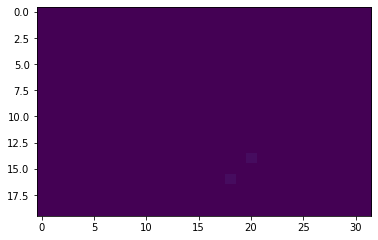

8357


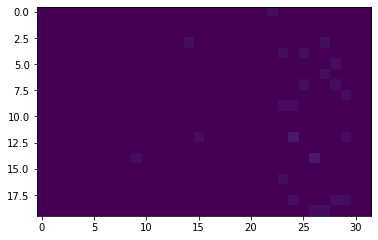

9269


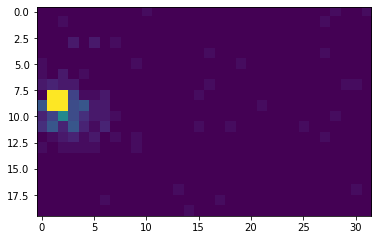

22063


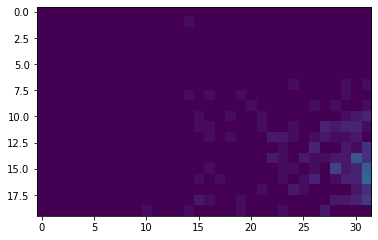

17477


In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsA]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(34000, 640)
(34005, 640)


In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
# print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[20413])
# print(x_train_scaled[20413])
# print(x_test[20413])
# print(x_test_scaled[20413])

## Build the autoencoder. 

Create our metrics, for example energy

In [10]:
import keras.backend as KK
import keras.callbacks as KKcall

In [11]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [12]:
# this model maps an input to its encoded representation
encoderA = Model(input_imgA, encodedA)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputA = Input(shape=(encoding_dimA,))
# retrieve the last layer of the autoencoder model
decoder_layerA = autoencoderA.layers[-1]
# create the decoder model
decoderA = Model(encoded_inputA, decoder_layerA(encoded_inputA))

autoencoderA.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderA.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [13]:
algoritmo='RMSprop'
experimento="scaledA_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}{}".format(encoding_dimA,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderA.fit(x_train_scaled, x_train_scaled,
                epochs=200,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Instructions for updating:
Use tf.cast instead.
Train on 34000 samples, validate on 34005 samples
Epoch 1/200
34000/34000 [==============================] - 1s 39us/step - loss: 14.6606 - energy_error: -47.6809 - val_loss: 15.0674 - val_energy_error: -13.5589
Epoch 2/200
34000/34000 [==============================] - 1s 23us/step - loss: 14.3593 - energy_error: -23.1856 - val_loss: 14.8444 - val_energy_error: -22.9168
Epoch 3/200
34000/34000 [==============================] - 1s 22us/step - loss: 14.1213 - energy_error: -28.8833 - val_loss: 14.6565 - val_energy_error: -31.6421
Epoch 4/200
34000/34000 [==============================] - 1s 18us/step - loss: 13.9233 - energy_error: -31.1952 - val_loss: 14.5009 - val_energy_error: -36.6441
Epoch 5/200
34000/34000 [==============================] - 1s 25us/step - loss: 13.7579 - energy_error: -31.1495 - val_loss: 14.3702 - val_energy_error: -39.4291
Epoch 6/200
34000/34000 [==============================] - 1s 27us/step - loss: 13.6173 - en

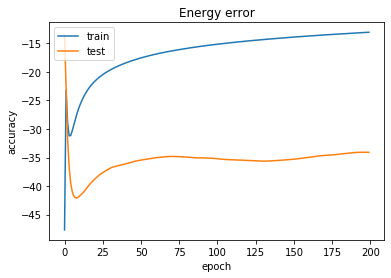

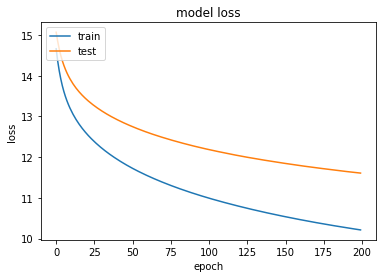

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# import pandas as pd 
# autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [16]:
autoencoderA.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimA,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [17]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [18]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderA.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


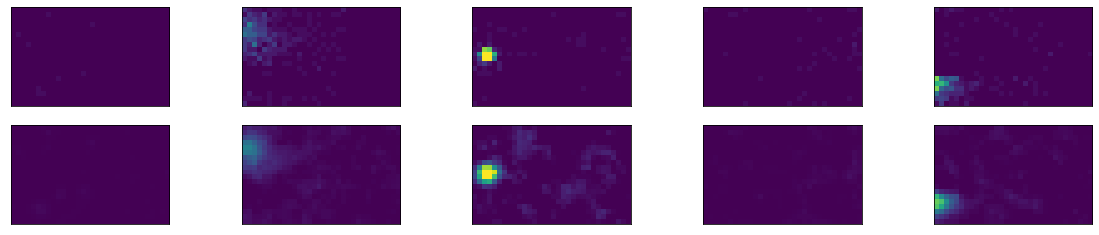

14664


In [19]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [20]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shapeB = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [21]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (6800, 15, 20, 1)


Display 20 random training images using image

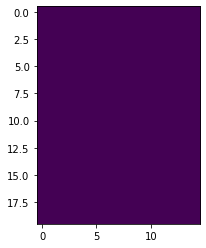

2524


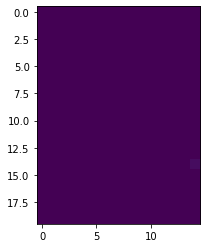

4138


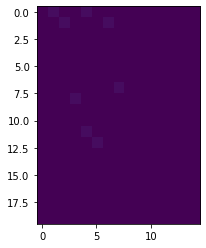

4177


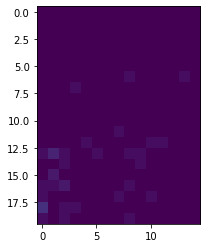

1914


In [22]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [23]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(6800, 300)
(6801, 300)


In [24]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
# print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[2413])
# print(x_train_scaled[2413])
# print(x_test[2413])
# print(x_test_scaled[2413])

## Build the autoencoder. 

Create our metrics, for example energy

In [25]:
import keras.backend as KK
import keras.callbacks as KKcall

In [26]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [27]:
# this model maps an input to its encoded representation
encoderB = Model(input_imgB, encodedB)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputB = Input(shape=(encoding_dimB,))
# retrieve the last layer of the autoencoder model
decoder_layerB = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_inputB, decoder_layerB(encoded_inputB))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [28]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}{}".format(encoding_dimB,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=1000,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 6800 samples, validate on 6801 samples
Epoch 1/1000
6800/6800 [==============================] - 0s 44us/step - loss: 11.9493 - energy_error: -57.2339 - val_loss: 12.6488 - val_energy_error: -37.1946
Epoch 2/1000
6800/6800 [==============================] - 0s 22us/step - loss: 11.7819 - energy_error: -30.3884 - val_loss: 12.5438 - val_energy_error: -19.5421
Epoch 3/1000
6800/6800 [==============================] - 0s 22us/step - loss: 11.6943 - energy_error: -17.8452 - val_loss: 12.4742 - val_energy_error: -11.7211
Epoch 4/1000
6800/6800 [==============================] - 0s 23us/step - loss: 11.6276 - energy_error: -12.8649 - val_loss: 12.4143 - val_energy_error: -9.2138
Epoch 5/1000
6800/6800 [==============================] - 0s 22us/step - loss: 11.5669 - energy_error: -11.2409 - val_loss: 12.3577 - val_energy_error: -8.5675
Epoch 6/1000
6800/6800 [==============================] - 0s 22us/step - loss: 11.5091 - energy_error: -10.7691 - val_loss: 12.3033 - val_energy_erro

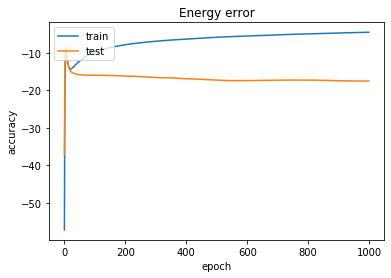

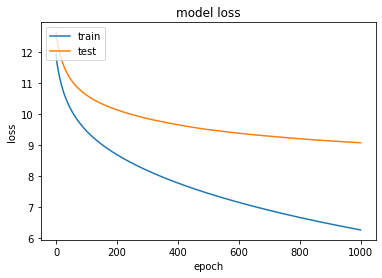

In [29]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# import pandas as pd 
# autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [31]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimB,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [32]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [33]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaledB = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaledB)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


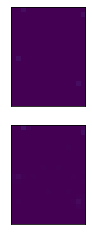

In [34]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [35]:
x_total=conjunto_datos[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,0: L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    

ValueError: Error when checking input: expected input_1 to have shape (640,) but got array with shape (600,)

In [ ]:
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse_idea=np.reshape(mse,(mse.shape[0],1))

In [ ]:
veamos=np.where((mse_idea<3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt=conjunto_datos_entradasA[veamos]

conjunto_datos_entradasB_filt=conjunto_datos_entradasB[veamos]

conjunto_datos_salidas_filt=conjunto_datos_salidas[veamos]

Salvamos los reusltados

In [ ]:
print(conjunto_datos_entradasA.shape)    
print(conjunto_datos_entradasA_filt.shape)    
print(conjunto_datos_entradasB_filt.shape)   
print(conjunto_datos_salidas_filt.shape)   

In [ ]:
np.savez('../conjuntos_datos_nuevos_2020/11_12_2019_filt2',conjunto_datos_entradasA_filt, conjunto_datos_entradasB_filt, conjunto_datos_salidas_filt)

## Visualizamos los resultados

Visualizamos todos los sensores: 

In [ ]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,cara_externa.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()